# Chapter 5. 정규선형모델

## 5.3 독립변수가 여럿인 모델

* 매상 예측 모델에서는 습도, 기온, 날씨(맑음 또는 비), 가격이라는 독립변수를 사용함

* 날씨는 카테고리, 그 외는 연속형 변수이지만 일반 선형모델 구조를 이용해서 통일적인 분석, 해석, 예측이 가능함

* **Type II ANOVA** : 복수의 독립변수가 있을 경우 그 변수들의 유의미함 판정

### 5.3.1 분석 준비

In [1]:
# 수치 계산에 사용하는 라이브러리
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 그래프를 그리기 위한 라이브러리
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 통계모델 추정에 사용하는 라이브러리
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 표시 자릿수 지정
%precision 3

# 그래프를 주피터 노트북에 그리기 위한 설정
%matplotlib inline

* 분석 대상이 되는 데이터 불러오기

    - 어느 가게의 가상의 매상 데이터. sales라는 변수에 저장

In [2]:
sales = pd.read_csv("py_source/5-3-1-lm-model.csv")

In [3]:
print(sales.head(3))

   humidity  price  sales  temperature weather
0      29.5    290  229.7         17.8   rainy
1      38.1    290  206.1         26.1   rainy
2      31.5    290  202.5         22.0   rainy


### 5.3.2 데이터로 그래프 그리기

* 독립변수가 여러개 있으므로 페어플랏을 그림

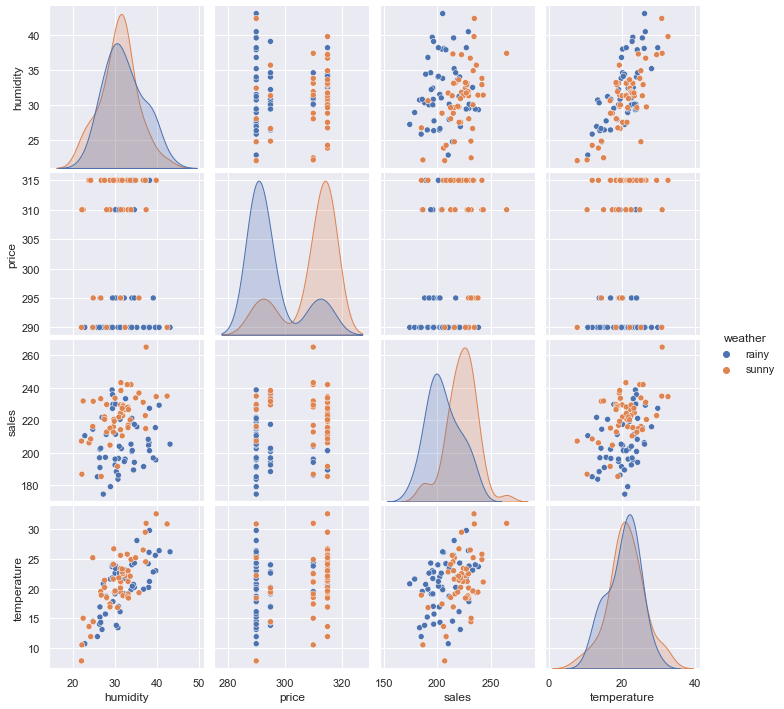

In [4]:
sns.pairplot(data = sales, hue = "weather")

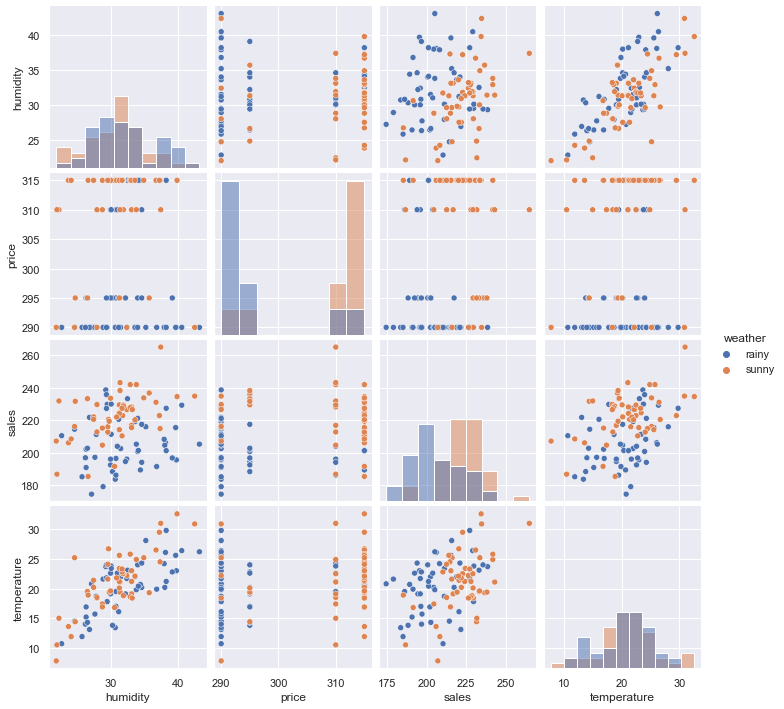

In [5]:
sns.pairplot(data = sales, hue = "weather", diag_kind = 'hist')

### 5.3.3 나쁜 분석 예: 변수가 1개인 모델 만들기

In [6]:
lm_dame = smf.ols("sales ~ price", sales).fit()

In [7]:
lm_dame.params

Intercept    113.645406
price          0.332812
dtype: float64

In [8]:
print(sm.stats.anova_lm(lm_dame, typ = 2))

                sum_sq    df         F    PR(>F)
price      1398.392322   1.0  4.970685  0.028064
Residual  27570.133578  98.0       NaN       NaN


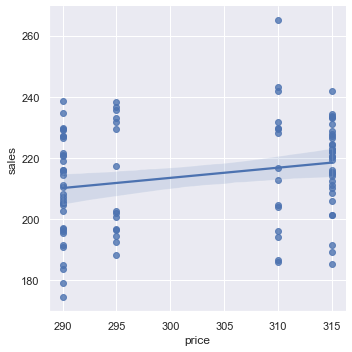

In [9]:
sns.lmplot(x = "price", y = "sales", data = sales)

* 위 결과를 정리하면 가격은 매상에 유의미한 영향이 있고, 가격이 오르면 매상도 증가한다는 고찰을 가져올 수 있을 것으로 보이나 맞지는 않음

### 5.3.4 독립변수 간의 관계 조사하기

In [10]:
print(sales.groupby("weather").mean())

         humidity  price    sales  temperature
weather                                       
rainy      32.126  295.5  205.924       20.422
sunny      30.852  309.5  222.718       21.102


* 출력 결과를 보면 비오는 날에는 매상이 떨어짐. 게다가 낮은 가격으로 억제되고 있음

    - 이는 비오는 날에는 매상이 떨어지기 때문에 그 대책으로 가격을 인하했다고 생각하는 것이 자연스러움


* 날씨가 같았을 때 상품 가격이 매상에 미치는 영향을 살펴보고자 아래와 같은 그래프를 도출

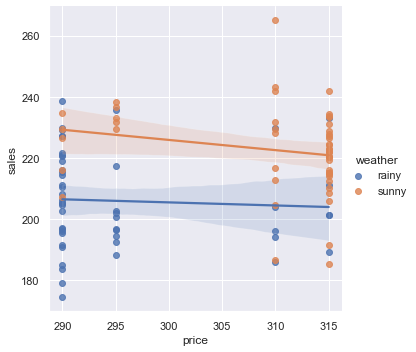

In [11]:
sns.lmplot(x = "price", y = "sales", data = sales, hue = "weather")

* 날씨별로 보면 가격이 높아지면 매상이 줄어드는 것을 알 수 있음

    - 방금 전과 비교해서 반대의 결론을 얻을 수 있음


* 맑은 날과 비오는 날 2번의 검정을 반복하게 되면 검정의 다중성 문제가 발생함

### 5.3.5 복수의 독립변수를 가지는 모델

* 독립변수를 + 기호로 연결하여 복수의 독립변수를 모델에 포함시킬 수 있음

In [12]:
# 복수의 독립변수를 가진 모델을 추정함

lm_sales = smf.ols("sales ~ weather + humidity + temperature + price", data = sales).fit()

In [13]:
lm_sales.params

Intercept           278.627722
weather[T.sunny]     19.989119
humidity             -0.254055
temperature           1.603115
price                -0.329207
dtype: float64

* 가장 먼저 주목해야 할 점은 가격 계수가 마이너스라는 점

    - 가격이 오르면 매상이 떨어진다는 것을 알 수 있음

### 5.3.6 나쁜 분석 예: 일반적인 분산분석으로 검정하기

* 독립변수가 종속변수에 영향을 끼치고 있다고 말할 수 있는지 검정을 이용해서 판단함

    - 이때 평범하게 분산분석을 하는 것은 문제가 있음

* **(분산분석 type)** https://www.r-bloggers.com/2011/03/anova-%e2%80%93-type-iiiiii-ss-explained/

* 우선 평범하게 분산분석을 실시( **```typ = 1```** 인수 입력)

In [14]:
print(sm.stats.anova_lm(lm_sales, typ = 1).round(3))

               df     sum_sq   mean_sq       F  PR(>F)
weather       1.0   7050.961  7050.961  38.848   0.000
humidity      1.0   1779.601  1779.601   9.805   0.002
temperature   1.0   2076.845  2076.845  11.443   0.001
price         1.0    818.402   818.402   4.509   0.036
Residual     95.0  17242.717   181.502     NaN     NaN


* 검정 결과를 보면 모든 독립변수가 유의한 것으로 나타남 

* 하지만 이 결과는 틀림. Type I ANOVA는 독립변수를 넣는 순서를 바꾸면 검정 결과가 바뀜

In [15]:
# 독립변수의 순서를 바꿈

lm_sales2 = smf.ols("sales ~ weather + temperature + humidity + price", data = sales).fit()

# 검정 결과 

print(sm.stats.anova_lm(lm_sales2, typ = 1).round(3))

               df     sum_sq   mean_sq       F  PR(>F)
weather       1.0   7050.961  7050.961  38.848   0.000
temperature   1.0   3814.779  3814.779  21.018   0.000
humidity      1.0     41.667    41.667   0.230   0.633
price         1.0    818.402   818.402   4.509   0.036
Residual     95.0  17242.717   181.502     NaN     NaN


* 독립변수에서 기온(temperature)과 습도(humidity)를 서로 바꿈

* 순서를 바꾼 것 뿐이라서 추정된 계수의 값 등은 일치함. 하지만 검정 결과는 일치하지 않음

* 2번째 모델에서는 습도의 p값이 0.6 정도로, 매상에 유의미한 영향을 끼치지 않는다는 결과가 되어 버림

### 5.3.7 회귀계수의 t검정

* 분산분석 대신 회귀계수의 t 검정을 하면 앞의 문제는 발생하지 않음

In [16]:
lm_sales.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,278.6277,46.335,6.013,0.000,186.641,370.615
weather[T.sunny],19.9891,3.522,5.675,0.000,12.997,26.982
humidity,-0.2541,0.456,-0.558,0.578,-1.159,0.651
temperature,1.6031,0.443,3.620,0.000,0.724,2.482
price,-0.3292,0.155,-2.123,0.036,-0.637,-0.021


In [17]:
lm_sales2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,278.6277,46.335,6.013,0.000,186.641,370.615
weather[T.sunny],19.9891,3.522,5.675,0.000,12.997,26.982
temperature,1.6031,0.443,3.620,0.000,0.724,2.482
humidity,-0.2541,0.456,-0.558,0.578,-1.159,0.651
price,-0.3292,0.155,-2.123,0.036,-0.637,-0.021


* 습도의 회귀계수 p 값은 0.578

* 하지만 날씨(카테고리형 변수)의 수준(level)이 맑음 또는 비 2가지 였기 때문에 가능함.

    - 만약 흐림이라는 날씨까지 있어서 수준(level)이 3가지이면, 검정 다중성의 문제가 발생할 수 있음

### 5.3.8 Type II ANOVA

* **Type II ANOVA** : 독립변수를 넣는 순서를 바꾸어도 검정 결과가 변하지 않는 분산분석

* 엄밀한 실험 계획에 따라 얻어진 데이터라면 **Type I ANOVA** 가 가지는 문제점을 크게 느끼지 않지만, 이번과 같은 경우에는 Type II ANOVA를 사용하는 것이 바람직함

> (ANOVA 타입 참고) https://blog.naver.com/shoutjoy/222176195243
> * **Type I SS** : SS(A), SS(B|A), SS(A*B|A,B) 
> * **Type II SS** : SS(A|B), SS(B|A), SS(A*B|A,B) 
> * **Type III SS** : SS(A|B, A*B), SS(B|A, A*B), SS(A*B|A,B) 

### 5.3.9 모델 선택과 분산분석

* Null 모델 

In [18]:
# Null 모델의 잔차제곱합

mod_null = smf.ols("sales ~ 1", sales).fit()
resid_sq_null = np.sum(mod_null.resid ** 2)
resid_sq_null

28968.526

In [19]:
# 날씨 모델의 잔차제곱합

mod_1 = smf.ols("sales ~ weather", sales).fit()
resid_sq_1 = np.sum(mod_1.resid ** 2)
resid_sq_1

21917.565

In [20]:
# 잔차 제곱합의 차 구하기

resid_sq_null - resid_sq_1

7050.961

* 이 값은 분산분석표에서도 등장함

In [21]:
print(sm.stats.anova_lm(mod_1).round(3))

            df     sum_sq   mean_sq       F  PR(>F)
weather    1.0   7050.961  7050.961  31.527     0.0
Residual  98.0  21917.565   223.649     NaN     NaN


* 날씨의 변화에 따른 군(그룹)간 편차제곱합은 모델에 날씨라는 독립변수를 추가하는 것으로 인해 감소하는 잔차제곱합과 일치한다고 할 수 있음

* 여기에 독립변수 humidity 추가하여 잔차제곱합 구함

In [22]:
# 날씨 + 습도 모델의 잔차제곱합

mod_2 = smf.ols("sales ~ weather + humidity", sales).fit()
resid_sq_2 = np.sum(mod_2.resid ** 2)
resid_sq_2

20137.964

In [23]:
# 날씨만 있는 모델의 잔차제곱합에서 날씨+습도가 들어간 모델의 잔차제곱합의 차이 산출

resid_sq_1 - resid_sq_2

1779.601

* 잔차제곱합의 차이는 분산분석표에서도 나타남

In [24]:
print(sm.stats.anova_lm(mod_2).round(3))

            df     sum_sq   mean_sq       F  PR(>F)
weather    1.0   7050.961  7050.961  33.963   0.000
humidity   1.0   1779.601  1779.601   8.572   0.004
Residual  97.0  20137.964   207.608     NaN     NaN


* 예를 들어 humidity의 F비는 1779.601 / 207.608로 계산할 수 있음

* 분모는 언제나 오차의 크기(207.608)을 사용하므로 weather의 F비는 1779.601 / 207.608로 계산할 수 있음

* 즉, 분산분석은 독립변수를 1개씩 늘려가며, 독립변수가 늘어남으로써 감소했던 잔차제곱합의 크기를 기반으로 독립변수 효과의 크기를 정량화 함

* 이 방법이라면 **독립변수를 추가하는 순서가 큰 의미를 가지게 됨**

In [25]:
# 날씨 + 기온 모델의 잔차제곱합

mod2_2 = smf.ols("sales ~ weather + temperature", data = sales).fit()
resid_sq_2_2 = np.sum(mod2_2.resid ** 2)
resid_sq_2_2

18102.786

* 다음은 날씨 + 기온 + 습도를 독립변수로 가지는 모델의 잔차제곱합을 구함

In [26]:
# 날씨 + 기온 + 습도 모델의 잔차제곱합

mod3_2 = smf.ols("sales ~ weather + temperature + humidity", data = sales).fit()
resid_sq_3_2 = np.sum(mod3_2.resid ** 2)
resid_sq_3_2

18061.119

* 잔차제곱합의 차이를 구하면 날씨 + 기온 모델에 습도를 추가함으로써 감소한 잔차 제곱합을 구할 수 있음

In [27]:
resid_sq_2_2 - resid_sq_3_2

41.667

* 이 값은 날씨만 있던 모델에 습도를 추가했을 때의 잔차제곱합의 감소량과 비교했을 때 작다는 점에 주목

    - 습도 효과의 크기가 작다는 의미
    
    - 검정을 하면 p값이 0.639가 되어 습도는 매상에 유의미한 영향을 끼치지 않는다는 결과가 나옴
    
    - 아래 분산분석표에서 sum_sq 열의 humidity 행을 보면 다시 확인할 수 있음

In [28]:
print(sm.stats.anova_lm(mod3_2).round(3))

               df     sum_sq   mean_sq       F  PR(>F)
weather       1.0   7050.961  7050.961  37.478   0.000
temperature   1.0   3814.779  3814.779  20.277   0.000
humidity      1.0     41.667    41.667   0.221   0.639
Residual     96.0  18061.119   188.137     NaN     NaN


* 복수의 독립변수를 가지는 경우 분산분석은 독립변수를 1개씩 늘려나가서 독립변수가 늘어남으로써 **감소한 잔차제곱합의 크기에 기반**(F비) 하여 독립변수가 가지는 효과의 크기(분산분석표의 sum_sq)를 계산함

* 이 방법이라면 독립변수를 추가하는 순서에 따라서 sum_sq 값의 크기가 크게 바뀜

    - 유의미한지 어떤지의 판단도 변하는 경우가 발생함
    
    - 이러한 검정 방법을 **Type I ANOVA**라고 하며, **독립변수가 여러개 있을 경우 Type I ANOVA를 사용하면 잘못된 결과를 얻을 가능성이 있음 !**

### 5.3.10 Type II ANOVA와 수정제곱합

* **Type I ANOVA** 는 아래와 같이 잔차 제곱합을 비교함

    - **모델0:** 매상 ~                            + 잔차제곱합
    - **모델1:** 매상 ~ 날씨                       + 잔차제곱합
    - **모델2:** 매상 ~ 날씨 + 습도                + 잔차제곱합
    - **모델3:** 매상 ~ 날씨 + 습도 + 기온         + 잔차제곱합
    - **모델4:** 매상 ~ 날씨 + 습도 + 기온 + 가격  + 잔차제곱합
    
* 모델 0과 1의 잔차제곱합을 비교하고, 모델 1과 2의 잔차제곱합을 비교하는 과정을 거쳐서 각 독립변수의 유의성을 검정함

* **Type II ANOVA**는 아래와 같이 잔차제곱합을 비교함

    - **모델0:** 매상 ~ 날씨 + 습도 + 기온 + 가격 + 잔차제곱합
    - **모델1:** 매상 ~        습도 + 기온 + 가격 + 잔차제곱합
    - **모델2:** 매상 ~ 날씨        + 기온 + 가격 + 잔차제곱합
    - **모델3:** 매상 ~ 날씨 + 습도        + 가격 + 잔차제곱합
    - **모델4:** 매상 ~ 날씨 + 습도 + 기온        + 잔차제곱합
    
* 모델 0과 모델 1을 비교하고, 모델 0과 2를 비교하고, 이와 같이 모두 모델 0의 잔차제곱합과 비교

*  **Type II ANOVA**는 독립변수가 줄어들면서 증가하는 잔차제곱합의 크기에 기반해서 독립변수가 갖는 효과의 크기를 정량화

    - 이 방식이라면 변수를 추가하는 순서를 바꾸어도 검정 결과는 달라지지 않음
    
    - 이 방법으로 계산된 군간 편차제곱합을 **수정제곱합**이라고 부름

### 5.3.11 Type II ANOVA(실습)

* **수정제곱합 계산**

    - 1. 모든 독립변수가 포함된 모델을 구축해서 잔차제곱합을 구함

In [29]:
# 모든 변수가 포함된 모델의 잔차제곱합
mod_full = smf.ols("sales ~ weather + humidity + temperature + price", sales).fit()
resid_sq_full = np.sum(mod_full.resid ** 2)
resid_sq_full

17242.717

* **수정제곱합 계산**

    - 2. 습도만 제거한 모델을 구축해서 잔차제곱합을 구함

In [30]:
# 습도만 제거한 모델의 잔차제곱합

mod_non_humi = smf.ols("sales ~ weather + temperature + price", sales).fit()
resid_sq_non_humi = np.sum(mod_non_humi.resid ** 2)
resid_sq_non_humi

17299.142

In [31]:
# 잔차제곱합의 차이
resid_sq_non_humi - resid_sq_full

56.425

* 수정제곱합을 이용한 분산분석인 Type II ANOVA는 typ = 2라는 파라미터를 넘김으로써 실행할 수 있음

* sum_sq 열의 humidity를 보면 위에서 계산한 결과와 같다는 것을 알 수 있음

In [32]:
print(sm.stats.anova_lm(mod_full, typ = 2).round(3))

                sum_sq    df       F  PR(>F)
weather       5845.878   1.0  32.208   0.000
humidity        56.425   1.0   0.311   0.578
temperature   2378.017   1.0  13.102   0.000
price          818.402   1.0   4.509   0.036
Residual     17242.717  95.0     NaN     NaN


* p값이 0.578이고, 습도는 매상에 대해 유의미한 영향을 끼치고 있다고 볼 수 없다는 결과를 얻음

* 독립변수가 1개밖에 없는 경우 **Type I ANOVA** 결과와 **Type II ANOVA**의 결과는 일치함

* 검정 결과 해석의 용이성을 고려했을 때 이 책에서는 **Type II ANOVA**의 사용을 권장함

* 또한 2개의 모델을 직접 비교하는 함수도 준비되어 있음

In [33]:
mod_full.compare_f_test(mod_non_humi)

(0.311, 0.578, 1.000)

* 출력으로 나온 3개의 값은 각각 F비, p값, 2개 모델의 자유도 차이

### 5.3.12 Type II ANOVA의 해석

* **Type II ANOVA** 에서 습도의 영향을 검정한 결과는 다른 독립변수가 있는 조건에서도 습도가 매상에 영향을 끼치고 있는지 판단할 수 있는 가를 조사한 것

* 습도는 기온과 강한 상관관계가 있음. 그렇다면 기온이라는 독립변수가 모델에 포함되어 있으면 습도는 매상에 영향을 끼친다고 볼 수 없게 되는 상황이 있을 수 있음

### 5.3.13 변수 선택과 모델 해석

* 습도를 뺀 모델 mod_non_humi에서 다시 **Type II ANOVA**를 수행

In [34]:
print(sm.stats.anova_lm(mod_non_humi, typ = 2).round(3))

                sum_sq    df       F  PR(>F)
weather       6354.966   1.0  35.266   0.000
temperature   4254.736   1.0  23.611   0.000
price          803.644   1.0   4.460   0.037
Residual     17299.142  96.0     NaN     NaN


* 이제 유의미하지 않은 변수가 없음 -> 이것으로 변수선택은 종료

* **계수 등의 결과에 대한 해석은 변수 선택 후의 모델을 이용해서 수행**

    - 잘못된 변수의 조합으로 모델링된 결과를 예측이나 해석에 사용하면 안됨

In [35]:
mod_non_humi.params

Intercept           273.301800
weather[T.sunny]     20.393871
temperature           1.417860
price                -0.326001
dtype: float64

* weather[T.sunny]는 비오는 날과 비교하면 매상이 20 증가한ㄴ다는 것을 의미함

    - 이러한 계수를 사용함으로써 매상의 예측 등을 수행할 수 있음
    

### 5.3.14 AIC를 이용한 변수 선택

* AIC를 이용해서 변수 선택을 실시

* AIC는 분산분석처럼 계산 방법을 바꿀 필요가 없음

* 우직하게 모델을 만들고, AIC를 비교하는 것 뿐

    * 예를 들어 모든 변수를 포함한 모델인 mod_full과 습도를 제외한 모델인 mod_non_humi의 AIC를 비교해 봄

In [36]:
print("모든변수를 포함한 모델 :" , mod_full.aic.round(3))
print("습도를 제외한 모델 :" , mod_non_humi.aic.round(3))

모든변수를 포함한 모델 : 808.785
습도를 제외한 모델 : 807.112


> **(코딩 스타일에 관한 재미있는 글)** https://blog.naver.com/ege1001/220466932974

* 습도를 제외한 모델의 AIC가 더 작아짐

* 이 때문에 습도는 매상 예측 모델에서 제외해야 함

* 원래는 모든 변수의 조합으로 AIC를 비교해야 함

     - AIC를 이용한 모델 선택은 절차적으로 보면 거의 기계적으로 수행 가능함
     
     - 계수의 t검정과 달리 여러 카테고리를 가진 변수라 하더라도 검정의 다중성을 걱정할 필요는 없음
     
     - 검정의 비대칭성 문제도 없으며, 최근 데이터 분석에서 AIC가 중요한 역할을 맡는 이유는 사용하기 편리하다는 장점이 있음
     
     - 하지만 검정의 p값을 맹신하면 안되듯 AIC도 과신해서는 안되며, 얻은 계수의 해석이나 변수 선택의 해석, 잔차 체크 등 포괄적인 평가를 수행하는 게 바람직함

### 5.3.15 다중공선성

* 독립변수 간 강한 상관관계가 있을 때 나타나는 문제가 **다중공선성**

* 이번 데이터에서는 기온과 습돈 간에 상관관계가 있었음 

    - 이런 경우 모델 해석에 주의가 필요하며 다중공선성이 있으면 추정된 계수의 해석이 어려워지기 때문에 변수 선택 후 그 결과를 이용해서 해석하는 것이 중요함

> https://datascienceschool.net/ (데이터 사이언스 스쿨 내용 발췌)

> * 다중공선성(multicollinearity)란 독립 변수의 일부가 다른 독립 변수의 조합으로 표현될 수 있는 경우이다. 독립 변수들이 서로 독립이 아니라 상호상관관계가 강한 경우에 발생한다. 이는 독립 변수의 공분산 행렬이 full rank 이어야 한다는 조건을 침해한다.
>    - 다음 데이터는 미국의 거시경제지표를 나타낸 것이다.
>        - TOTEMP - Total Employment
>        - GNPDEFL - GNP deflator
>        - GNP - GNP
>        - UNEMP - Number of unemployed
>        - ARMED - Size of armed forces
>        - POP - Population
>        - YEAR - Year (1947 - 1962)
> * 스캐터 플롯에서 보듯이 독립변수간의 상관관계가 강하다.

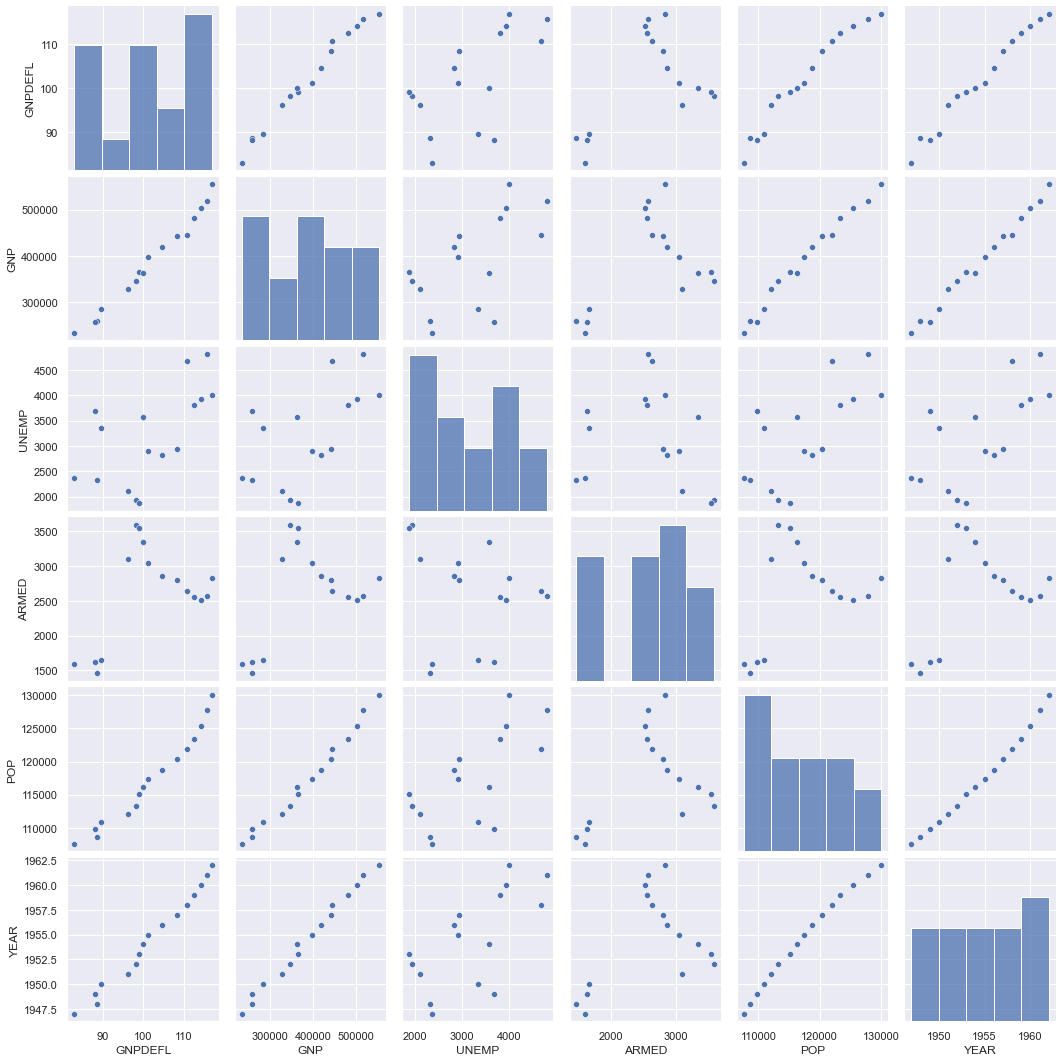

In [37]:
from statsmodels.datasets.longley import load_pandas

dfy = load_pandas().endog
dfX = load_pandas().exog
df = pd.concat([dfy, dfX], axis=1)
sns.pairplot(dfX)
plt.show()

In [38]:
dfX.corr()

,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
GNPDEFL,1.000000,0.991589,0.620633,0.464744,0.979163,0.991149
GNP,0.991589,1.000000,0.604261,0.446437,0.991090,0.995273
UNEMP,0.620633,0.604261,1.000000,-0.177421,0.686552,0.668257
ARMED,0.464744,0.446437,-0.177421,1.000000,0.364416,0.417245
POP,0.979163,0.991090,0.686552,0.364416,1.000000,0.993953
YEAR,0.991149,0.995273,0.668257,0.417245,0.993953,1.000000


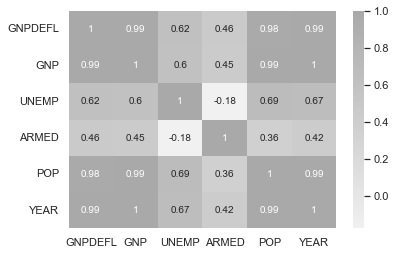

In [39]:
cmap = sns.light_palette("darkgray", as_cmap=True)
sns.heatmap(dfX.corr(), annot=True, cmap=cmap)
plt.show()

* 다중 공선성이 있으면 독립변수의 공분산 행렬의 조건수(conditional number)가 증가한다.

* 또한 학습용 데이터와 검증용 데이터로 나누어 회귀분석 성능을 비교하면 과최적화가 발생하였음을 알 수 있다.

In [40]:
from sklearn.model_selection import train_test_split

def get_model1(seed):
    df_train, df_test = train_test_split(df, test_size=0.5, random_state=seed)
    model = sm.OLS.from_formula("TOTEMP ~ GNPDEFL + POP + GNP + YEAR + ARMED + UNEMP", data=df_train)
    return df_train, df_test, model.fit()


df_train, df_test, result1 = get_model1(3)
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     437.5
Date:                Sun, 18 Sep 2022   Prob (F-statistic):             0.0366
Time:                        19:15:04   Log-Likelihood:                -44.199
No. Observations:                   8   AIC:                             102.4
Df Residuals:                       1   BIC:                             103.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.235e+07   2.97e+06     -4.165      0.1

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [41]:
def calc_r2(df_test, result):
    target = df.loc[df_test.index].TOTEMP
    predict_test = result.predict(df_test)
    RSS = ((predict_test - target)**2).sum()
    TSS = ((target - target.mean())**2).sum()
    return 1 - RSS / TSS


test1 = []
for i in range(10):
    df_train, df_test, result = get_model1(i)
    test1.append(calc_r2(df_test, result))

test1

[0.982, 0.974, 0.988, 0.759, 0.981, 0.894, 0.880, 0.931, 0.861, 0.968]

- 독립변수가 서로 의존하게 되면 이렇게 과최적화(over-fitting) 문제가 발생하여 회귀 결과의 안정성을 해칠 가능성이 높아진다. 이를 방지하는 방법들은 다음과 같다.

    * 변수 선택법으로 의존적인 변수 삭제

    * PCA(principal component analysis) 방법으로 의존적인 성분 삭제

    * 정규화(regularized) 방법 사용

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif

,VIF Factor,features
0,12425.514335,GNPDEFL
1,10290.435437,GNP
2,136.224354,UNEMP
3,39.983386,ARMED
4,101193.161993,POP
5,84709.950443,YEAR


* 상관계수와 VIF를 사용하여 독립 변수를 선택하면 GNP, ARMED, UNEMP 세가지 변수만으로도 비슷한 수준의 성능이 나온다는 것을 알 수 있다.

In [43]:
def get_model2(seed):
    df_train, df_test = train_test_split(df, test_size=0.5, random_state=seed)
    model = sm.OLS.from_formula("TOTEMP ~ scale(GNP) + scale(ARMED) + scale(UNEMP)", data=df_train)
    return df_train, df_test, model.fit()


df_train, df_test, result2 = get_model2(3)
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     118.6
Date:                Sun, 18 Sep 2022   Prob (F-statistic):           0.000231
Time:                        19:15:04   Log-Likelihood:                -57.695
No. Observations:                   8   AIC:                             123.4
Df Residuals:                       4   BIC:                             123.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.538e+04    163.988    398.686   

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


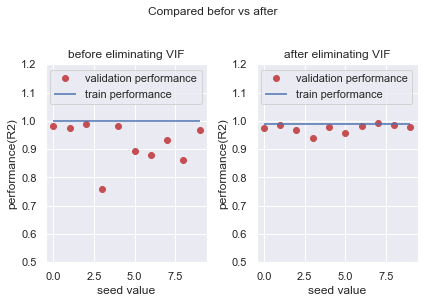

In [44]:
test2 = []
for i in range(10):
    df_train, df_test, result = get_model2(i)
    test2.append(calc_r2(df_test, result))

test2

plt.subplot(121)
plt.plot(test1, 'ro', label="validation performance")
plt.hlines(result1.rsquared, 0, 9, label="train performance")
plt.legend()
plt.xlabel("seed value")
plt.ylabel("performance(R2)")
plt.title("before eliminating VIF")
plt.ylim(0.5, 1.2)

plt.subplot(122)
plt.plot(test2, 'ro', label="validation performance")
plt.hlines(result2.rsquared, 0, 9, label="train performance")
plt.legend()
plt.xlabel("seed value")
plt.ylabel("performance(R2)")
plt.title("after eliminating VIF")
plt.ylim(0.5, 1.2)

plt.suptitle("Compared befor vs after", y=1.04)
plt.tight_layout()
plt.show()